# Grouped Pointwise Convolution Neural Network Implementation

This notebook implements the grouped pointwise convolution neural network on MobileNet Architecture with CIFAR-10 dataset The document includes:

1.	Cloning the package from github repository
2.	Import Statements
3.	Floating Point Operations Count
4.	Dataset: CIFAR-10
5.	Base Parameters
6.	Cyclic Learning Rate Scheduler
7.	Generate MobileNet Model
8.	Generate Model
9.	Training the model
10.	Plotting Accuracy and Loss
11.	Evaluation of Results
12.	The Implemented Achitecture

# Cloning the package from github repository

In [1]:
import os

if not os.path.isdir('gp'):
 !git clone -b main https://github.com/itsaravindanand/gpc-api.git gp
else:
 !cd gp && git pull

!cd gp && pip install .

Already up to date.
Processing c:\users\itsar\cecs551_project\gp
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for gpc: filename=gpc-0.1.1-py3-none-any.whl size=24930 sha256=5f6dd2f2c78c68182fd5a5ed19b5412f7de4d6a6bd1e2c4c5ebf9fb63de5afdd
  Stored in directory: C:\Users\itsar\AppData\Local\Temp\pip-ephem-wheel-cache-dtfn3ap8\wheels\c9\1f\4c\74356d7b2e990778f763d26528877e2bbb67519580a5799b17
Successfully built gpc
  Attempting uninstall: gpc
    Found existing installation: gpc 0.1.1
    Uninstalling gpc-0.1.1:
      Successfully uninstalled gpc-0.1.1


# Import Statements

In [2]:
import gpc.datasets
import gpc.models
import gpc.layers
import gpc.mobilenet_v1
import numpy as np
from tensorflow import keras
from tensorflow.keras import mixed_precision
import gc
import multiprocessing
import random
import os
import matplotlib.pyplot as plt
import tensorflow as tf
print("Tensorflow version:", tf.version.VERSION)
print("Keras version:", keras.__version__)
from sklearn.metrics import classification_report

Tensorflow version: 2.10.1
Keras version: 2.10.0


# Floating Point Operations Count

The provided get_flops function is designed to calculate the number of floating-point operations (FLOPs) required for a single forward pass in a TensorFlow model. Understanding FLOPs is crucial in assessing the computational complexity of neural networks. 

In [3]:
from tensorflow.python.profiler.model_analyzer import profile
from tensorflow.python.profiler.option_builder import ProfileOptionBuilder

def get_flops(model):
  forward_pass = tf.function(
      model.call,
      input_signature=[tf.TensorSpec(shape=(1,) + model.input_shape[1:])])

  graph_info = profile(forward_pass.get_concrete_function().graph,
                          options=ProfileOptionBuilder.float_operation())

  # The //2 is necessary since `profile` counts multiply and accumulate
  # as two flops, here we report the total number of multiply accumulate ops
  flops = graph_info.total_float_ops // 2
  return flops

# Dataset: CIFAR-10

Loads the CIFAR-10 dataset, creates the necessary directories, and saves the dataset images as PNG files.

In [4]:
verbose=True
root_folder = 'cifar10-as-png'
data_dir = root_folder + '/train';
test_dir = root_folder + '/test';

if not os.path.isdir(root_folder):
  x_train, y_train, x_test, y_test = gpc.datasets.load_dataset(tf.keras.datasets.cifar10, verbose=verbose, lab=False, bipolar=False)
  os.mkdir(root_folder)
  gpc.datasets.save_dataset_as_png(gpc.datasets.fix_bad_tfkeras_channel_order(x_train)*255, y_train, dest_folder_name=data_dir)
  gpc.datasets.save_dataset_as_png(gpc.datasets.fix_bad_tfkeras_channel_order(x_test)*255, y_test, dest_folder_name=test_dir)

# Base Parameters

The batch size and epochs can be modified as per the requirement.

In [5]:
num_classes = 10
batch_size = 16
epochs = 50
target_size_x = 224
target_size_y = 224
seed = 12

# Cyclic Learning Rate Scheduler

This function will aid in scheduling the learning rate as per the epoch count

In [6]:
train_datagen = gpc.util.create_image_generator(validation_split=0.1, rotation_range=20, width_shift_range=0.3, height_shift_range=0.3, channel_shift_range=0.0, rescale=1./255)
test_datagen = gpc.util.create_image_generator_no_augmentation(rescale=1./255)
cpus_num = max([multiprocessing.cpu_count(), 8])

def cyclic_learningRate_Scheduler(epoch):
    #gpc Cyclic Learning Rate Scheduler.
    
    base_learning = 0.001
    local_epoch = epoch % 25
    if local_epoch < 7:
       return base_learning * (1 + 0.5*local_epoch)
    else:
       return (base_learning * 4) * ( 0.85**(local_epoch-7) )

# Generate MobileNet Model

The method gpc_mobilenetV1 provides the facility to compile, training and test the proposed architecture. All the functionalities are given in a single method for streamlined workflow, consistent configuration and ease of use.

In [7]:
def gpc_mobilenetV1(generate_model=False, model_fit=False, eval_results=False):
    monitor = 'val_accuracy'
    if generate_model:
        input_shape = (target_size_x, target_size_y, 3)
    else:
        input_shape = (None, None, 3)

    # Directly set the gpcType value for the required architecture
    #gpc values and the respective architecture
    # -1 => default MobileNet Architecture
    # 1 => Grouped Pointwise Convolution MobileNet Architecture with 16 channels 
    # 2 => Grouped Pointwise Convolution MobileNet Architecture with 32 channels 
    # 3 => Grouped Pointwise Convolution MobileNet Architecture with 64 channels 
    # 4 => Grouped Pointwise Convolution MobileNet Architecture with 128 channels 
    gpcType = 3  

    basefilename = 'GPC-mobilenet-CIFAR10-' + str(gpcType)
    best_result_file_name = basefilename + '-best_result.hdf5'
    print('Running: ' + basefilename)

    if gpcType == -1:
        model = gpc.mobilenet_v1.MobileNet(
            include_top=True,
            weights=None,
            input_tensor=None,
            input_shape=input_shape,
            pooling=None,
            classes=num_classes)
    else:
        model = gpc.mobilenet_v1.gpcMobileNet(
            include_top=True,
            weights=None,
            input_shape=input_shape,
            pooling=None,
            classes=num_classes,
            gpcType=gpcType)

    optimizer = keras.optimizers.RMSprop()
    optimizer = mixed_precision.LossScaleOptimizer(optimizer)
    model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy'])

    if generate_model:
        model.summary()
        print('model flops:', get_flops(model))

    save_best = keras.callbacks.ModelCheckpoint(
        filepath=best_result_file_name,
        monitor=monitor,
        verbose=1,
        save_best_only=True,
        save_weights_only=False,
        mode='max',
        save_freq='epoch')

    if model_fit:
        train_flow = train_datagen.flow_from_directory(
            directory=data_dir,
            subset="training",
            target_size=(target_size_x, target_size_y),
            color_mode="rgb",
            batch_size=batch_size,
            class_mode="categorical",
            shuffle=True,
            seed=seed
        )
        validation_flow = train_datagen.flow_from_directory(
            directory=data_dir,
            subset="validation",
            target_size=(target_size_x, target_size_y),
            color_mode="rgb",
            batch_size=batch_size,
            class_mode="categorical",
            shuffle=True,
            seed=seed
        )
        history = model.fit(
            x=train_flow,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=validation_flow,
            callbacks=[save_best, tf.keras.callbacks.LearningRateScheduler(cyclic_learningRate_Scheduler)],
            workers=cpus_num,
            max_queue_size=128
        )
        return history

    if eval_results:
        test_flow = test_datagen.flow_from_directory(
            directory=test_dir,
            target_size=(target_size_x, target_size_y),
            color_mode="rgb",
            batch_size=batch_size,
            class_mode="categorical",
            shuffle=True,
            seed=seed
        )
        print('Best Model Results: ' + best_result_file_name)
        model = gpc.models.load_kereas_model(best_result_file_name)
        evaluated = model.evaluate(
            x=test_flow,
            batch_size=batch_size,
            use_multiprocessing=False,
            workers=cpus_num
        )
        for metric, name in zip(evaluated, ["loss", "acc"]):
            print(name, metric)
            
    print('Finished: ' + basefilename)

# Generate Model

In [8]:
gpc_mobilenetV1(generate_model=True, model_fit=False, eval_results=False)

Running: GPC-mobilenet-CIFAR10-3
Model: "gpcmobilenetv1-3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 225, 225, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1 (Conv2D)                 (None, 112, 112, 32  864         ['conv1_pad[0][0]']              
                                )                                                                 
                                                  

# Training the model

In [9]:
history = gpc_mobilenetV1(generate_model=False, model_fit=True, eval_results=False)

Running: GPC-mobilenet-CIFAR10-3
Found 45000 images belonging to 10 classes.
Found 5000 images belonging to 10 classes.
Epoch 1/50
2813/2813 [==============================] - ETA: 0s - loss: 1.8766 - accuracy: 0.3148
Epoch 1: val_accuracy improved from -inf to 0.36620, saving model to GPC-mobilenet-CIFAR10-3-best_result.hdf5
2813/2813 [==============================] - 532s 183ms/step - loss: 1.8766 - accuracy: 0.3148 - val_loss: 1.8335 - val_accuracy: 0.3662 - lr: 0.0010
Epoch 2/50
2813/2813 [==============================] - ETA: 0s - loss: 1.4394 - accuracy: 0.4914
Epoch 2: val_accuracy improved from 0.36620 to 0.49520, saving model to GPC-mobilenet-CIFAR10-3-best_result.hdf5
2813/2813 [==============================] - 513s 182ms/step - loss: 1.4394 - accuracy: 0.4914 - val_loss: 1.5254 - val_accuracy: 0.4952 - lr: 0.0015
Epoch 3/50
2813/2813 [==============================] - ETA: 0s - loss: 1.2018 - accuracy: 0.5820
Epoch 3: val_accuracy improved from 0.49520 to 0.59420, saving 

# Plotting Accuracy and Loss

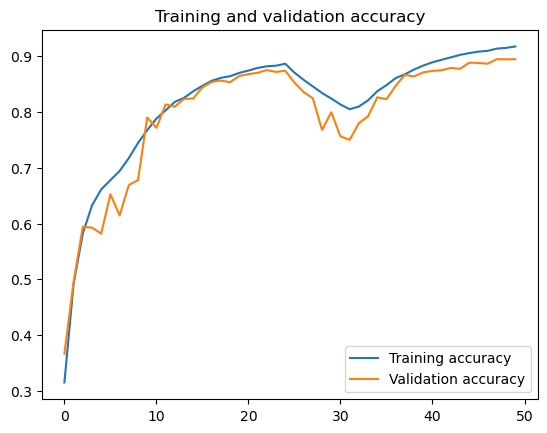

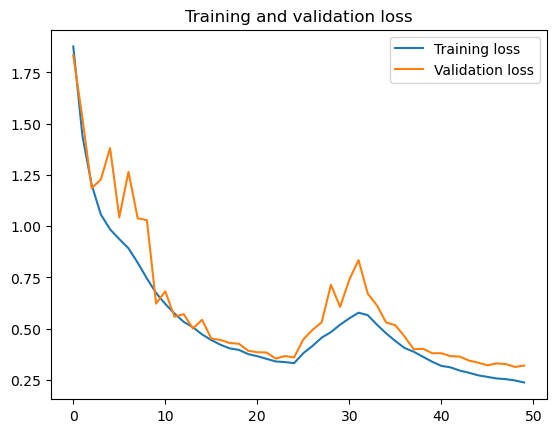

In [10]:
# Plot the accuracy and loss curves
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epoch_range = range(len(acc))

plt.plot(epoch_range, acc, label='Training accuracy')
plt.plot(epoch_range, val_acc, label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epoch_range, loss, label='Training loss')
plt.plot(epoch_range, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Evaluation of Results

In [11]:
gpc_mobilenetV1(generate_model=False, model_fit=False, eval_results=True)

Running: GPC-mobilenet-CIFAR10-3
Found 10000 images belonging to 10 classes.
Best Model Results: GPC-mobilenet-CIFAR10-3-best_result.hdf5
625/625 [==============================] - 26s 35ms/step - loss: 0.2725 - accuracy: 0.9196
loss 0.27246373891830444
acc 0.9196000099182129
Finished: GPC-mobilenet-CIFAR10-3


# The Implemented Architecture

The below code snippets depict the modified MobileNet CNN and the convolutional layers creation which performs the core methodology of creating the GPC with interleaving channels. 

In [1]:
# Modified GPC MobileNetV1 - gpcMobileNet:
# def gpcMobileNet(input_shape=None, alpha=1.0, depth_multiplier=1, dropout=1e-3, include_top=True, weights=None, input_tensor=None, pooling=None, classes=1000, activation=keras.activations.swish, gpcType=0):
    
#     img_input = keras.layers.Input(shape=input_shape)

#     x = _conv_block(img_input, 32, alpha, strides=(2, 2))
#     x = gpcdepthwise_conv_block(x, 64, alpha, depth_multiplier, block_id=1, activation=activation, gpcType=gpcType)

#     x = gpcdepthwise_conv_block(x, 128, alpha, depth_multiplier, strides=(2, 2), block_id=2, activation=activation,
#                                 gpcType=gpcType)
#     x = gpcdepthwise_conv_block(x, 128, alpha, depth_multiplier, block_id=3, activation=activation, gpcType=gpcType)

#     x = gpcdepthwise_conv_block(x, 256, alpha, depth_multiplier, strides=(2, 2), block_id=4, activation=activation,
#                                 gpcType=gpcType)
#     x = gpcdepthwise_conv_block(x, 256, alpha, depth_multiplier, block_id=5, activation=activation, gpcType=gpcType)

#     x = gpcdepthwise_conv_block(x, 512, alpha, depth_multiplier, strides=(2, 2), block_id=6, activation=activation,
#                                 gpcType=gpcType)
#     x = gpcdepthwise_conv_block(x, 512, alpha, depth_multiplier, block_id=7, activation=activation, gpcType=gpcType)
#     x = gpcdepthwise_conv_block(x, 512, alpha, depth_multiplier, block_id=8, activation=activation, gpcType=gpcType)
#     x = gpcdepthwise_conv_block(x, 512, alpha, depth_multiplier, block_id=9, activation=activation, gpcType=gpcType)
#     x = gpcdepthwise_conv_block(x, 512, alpha, depth_multiplier, block_id=10, activation=activation, gpcType=gpcType)
#     x = gpcdepthwise_conv_block(x, 512, alpha, depth_multiplier, block_id=11, activation=activation, gpcType=gpcType)

#     x = gpcdepthwise_conv_block(x, 1024, alpha, depth_multiplier, strides=(2, 2), block_id=12, activation=activation,
#                                 gpcType=gpcType)
#     x = gpcdepthwise_conv_block(x, 1024, alpha, depth_multiplier, block_id=13, activation=activation, gpcType=gpcType)

#     if include_top:
#         if backend.image_data_format() == 'channels_first':
#             shape = (int(1024 * alpha), 1, 1)
#         else:
#             shape = (1, 1, int(1024 * alpha))

#         x = layers.GlobalAveragePooling2D()(x)
#         x = layers.Reshape(shape, name='reshape_1')(x)
#         x = layers.Dropout(dropout, name='dropout')(x)
#         # The last dense layer should not be optimized.
#         x = layers.Conv2D(classes, (1, 1),
#                           padding='same',
#                           name='conv_preds')(x)
#         x = layers.Activation('softmax', name='act_softmax')(x)
#     else:
#         if pooling == 'avg':
#             x = layers.GlobalAveragePooling2D()(x)
#         elif pooling == 'max':
#             x = layers.GlobalMaxPooling2D()(x)

#     inputs = img_input

#     # Create model.
#     model = keras.models.Model(inputs, x, name='gpcmobilenetv1-' + str(gpcType))

#     return model

In [2]:
# gpcdepthwise_conv_block code:
# def gpcdepthwise_conv_block(inputs, pointwise_conv_filters, alpha,
#                             depth_multiplier=1, strides=(1, 1), block_id=1,
#                             activation=keras.activations.swish,
#                             gpcType=0):
#         channel_axis = gpc.layers.GetChannelAxis()

#     pointwise_conv_filters = int(pointwise_conv_filters * alpha)

#     if strides == (1, 1):
#         x = inputs
#     else:
#         x = layers.ZeroPadding2D(((0, 1), (0, 1)),
#                                  name='conv_pad_%d' % block_id)(inputs)
#     x = layers.DepthwiseConv2D((3, 3),
#                                padding='same' if strides == (1, 1) else 'valid',
#                                depth_multiplier=depth_multiplier,
#                                strides=strides,
#                                use_bias=False,
#                                name='conv_dw_%d' % block_id)(x)
#     x = layers.BatchNormalization(
#         axis=channel_axis, name='conv_dw_%d_bn' % block_id)(x)
#     x = layers.ReLU(6., name='conv_dw_%d_relu' % block_id)(x)
#     x = gpc.layers.gpcPointwiseConv2D(x, filters=pointwise_conv_filters, channel_axis=channel_axis,
#                                       name='conv_pw_%d_bn' % block_id, activation=activation, has_batch_norm=True,
#                                       use_bias=False, gpcType=gpcType)
#     return x 

In [3]:
# gpcPointwiseConv2D code:
# def gpcPointwiseConv2D(last_tensor, filters=32, channel_axis=3, name=None, activation=None, has_batch_norm=True, has_batch_scale=True, use_bias=True, gpcType=0):
#     return gpcConv2D(last_tensor, filters=filters, channel_axis=channel_axis, name=name, activation=activation, has_batch_norm=has_batch_norm, has_batch_scale=has_batch_scale, use_bias=use_bias, kernel_size=1, stride_size=1, padding='same', gpcType=gpcType)

In [4]:
# gpcConv2D | Code that decides the channel count based execution:
# def gpcConv2D(last_tensor, filters=32, channel_axis=3, name=None, activation=None, has_batch_norm=True, has_batch_scale=True, use_bias=True, kernel_size=1, stride_size=1, padding='same', gpcType=0):
#     prev_layer_channel_count = tensorflow.keras.backend.int_shape(last_tensor)[channel_axis]
#     if gpcType == 1:
#         #16 Channels
#         return gpcConv2DType2(last_tensor, filters=filters, channel_axis=channel_axis, name=name, activation=activation, has_batch_norm=has_batch_norm, has_batch_scale=has_batch_scale, use_bias=use_bias, kernel_size=kernel_size, stride_size=stride_size, padding=padding, min_channels_per_group=16)
#     elif gpcType == 2:
#         #32 Channels
#         return gpcConv2DType2(last_tensor, filters=filters, channel_axis=channel_axis, name=name, activation=activation, has_batch_norm=has_batch_norm, has_batch_scale=has_batch_scale, use_bias=use_bias, kernel_size=kernel_size, stride_size=stride_size, padding=padding, min_channels_per_group=32)
#     elif gpcType == 3:
#         #64 Channels
#         return gpcConv2DType2(last_tensor, filters=filters, channel_axis=channel_axis, name=name, activation=activation, has_batch_norm=has_batch_norm, has_batch_scale=has_batch_scale, use_bias=use_bias, kernel_size=kernel_size, stride_size=stride_size, padding=padding, min_channels_per_group=64)
#     elif gpcType == 4:
#         #128 Channels
#         return gpcConv2DType2(last_tensor, filters=filters, channel_axis=channel_axis, name=name, activation=activation, has_batch_norm=has_batch_norm, has_batch_scale=has_batch_scale, use_bias=use_bias, kernel_size=kernel_size, stride_size=stride_size, padding=padding, min_channels_per_group=128)

In [5]:
# The below method (gpcConv2DType2) does the following steps:
# - This code segment from the gpcConv2DType2 function in the project report is designed to apply grouped convolutions to the input tensor, last_tensor. 
# - It starts by determining the number of groups for the convolution based on the input and output channel counts. 
# - If the group count is more than one, it applies a convolution operation with group-wise separation (conv2d_bn), followed by an interleaving of channels (InterleaveChannels) for enhanced feature extraction. 
# - If the input channel count is greater or equal to the output channel count, another grouped convolution is applied for inter-group connections. 
# - The final output tensor is the sum of the grouped convolution output and the original input tensor, which helps in maintaining feature integrity while reducing parameters.

# gpcConv2DType2 | Code that creates the GPC layer:
# def gpcConv2DType2(last_tensor,  filters=32,  channel_axis=3,  name=None, activation=None, has_batch_norm=True, has_batch_scale=True, use_bias=True, kernel_size=1, stride_size=1, padding='same', min_channels_per_group=16):
    
#     prev_layer_channel_count = tensorflow.keras.backend.int_shape(last_tensor)[channel_axis]
#     output_channel_count = filters
#     max_acceptable_divisor = (prev_layer_channel_count//min_channels_per_group)
#     group_count = gpc.util.get_max_acceptable_common_divisor(prev_layer_channel_count, output_channel_count, max_acceptable = max_acceptable_divisor)
    
#     if group_count is None: group_count=1
#     output_group_size = output_channel_count // group_count
    
#     if (group_count>1):
#     output_tensor = conv2d_bn(output_tensor, output_channel_count, kernel_size, kernel_size, name=name, activation=activation, has_batch_norm=has_batch_norm, has_batch_scale=has_batch_scale, groups=group_count, use_bias=use_bias, strides=(stride_size, stride_size), padding=padding)
#         compression_tensor = output_tensor
#         if output_group_size > 1:
#             output_tensor = InterleaveChannels(output_group_size, name=name+'_group_interleaved')(output_tensor)
#         if (prev_layer_channel_count >= output_channel_count):
#             output_tensor = conv2d_bn(output_tensor, output_channel_count, 1, 1, name=name+'_group_interconnect', activation=activation, has_batch_norm=has_batch_norm, has_batch_scale=has_batch_scale, groups=group_count, use_bias=use_bias)
#             output_tensor = tensorflow.keras.layers.add([output_tensor, compression_tensor], name=name+'_inter_group_add')
#     else:
#         output_tensor = conv2d_bn(output_tensor, output_channel_count, kernel_size, kernel_size, name=name, activation=activation, has_batch_norm=has_batch_norm, has_batch_scale=has_batch_scale, use_bias=use_bias)
    
#     return output_tensor